# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

import seaborn as sns
sns.set()

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    step = 100
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2

        axes_pair[0].scatter(flatten_image[::step, first_color], flatten_image[::step, second_color], c=flatten_image[::step], marker='.')
        axes_pair[1].scatter(flatten_image[::step, first_color], flatten_image[::step, second_color], c=cluster_colors[cluster_labels][::step], marker='.')

        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

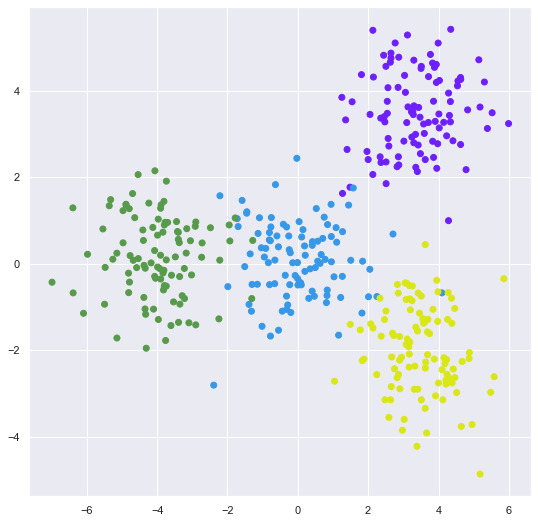

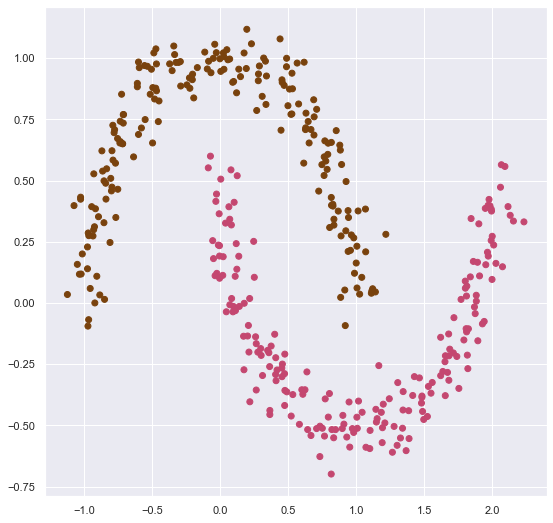

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = []


    def _init_random(self, X):
        rng = np.random.default_rng()
        min_bound, max_bound = np.min(X, axis=0), np.max(X, axis=0)
        self.centroids = rng.uniform(min_bound, max_bound, size=(self.n_clusters, X.shape[1]))

    def _init_sample(self, X):
        rng = np.random.default_rng()
        centroid_ids = rng.choice(X.shape[0], size=self.n_clusters, replace=False)
        self.centroids = X[centroid_ids]


    def _init_kmeans_pp(self, X):
        self.centroids = np.zeros(shape=(self.n_clusters, X.shape[1]))
        rng = np.random.default_rng()
        center = X[rng.choice(X.shape[0])]
        d = np.linalg.norm(X - center, axis=1) ** 2
        for i in range(self.n_clusters):
            center = X[rng.choice(X.shape[0], p = d / np.sum(d))]
            d_new = np.power(np.linalg.norm(X - center, axis=1), 2)
            d = np.minimum(d, d_new)
            self.centroids[i] = center

    def _get_distances(self, X, Y):
        return np.sqrt(np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1, keepdims=True) - 2 * X @ Y.T)

    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        if self.init == "random":
            self._init_random(X)

        elif self.init == "sample":
            self._init_sample(X)

        elif self.init == "k-means++":
            self._init_kmeans_pp(X)
        
        point_type = np.zeros(X.shape[0])  # every point -> 0th centroid
        for _ in range(self.max_iter):
            D = self._get_distances(X, self.centroids)
            new_point_type = np.argmin(D, axis=1)

            #  if no cluster types were changed => no reason to continue
            if np.all(point_type == new_point_type):
                break

            for i in range(self.n_clusters):
                if np.sum(new_point_type == i):
                    self.centroids[i] = np.mean(X[new_point_type == i], axis=0)
                else:  # unfortunate random init, got empty centroid => move it
                    self.centroids[i] = X[np.random.choice(X.shape[0])]
            
            point_type = new_point_type
                
                
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        if self.centroids is None:
            raise ValueError()
        return np.argmin(self._get_distances(X, self.centroids), axis=1)
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

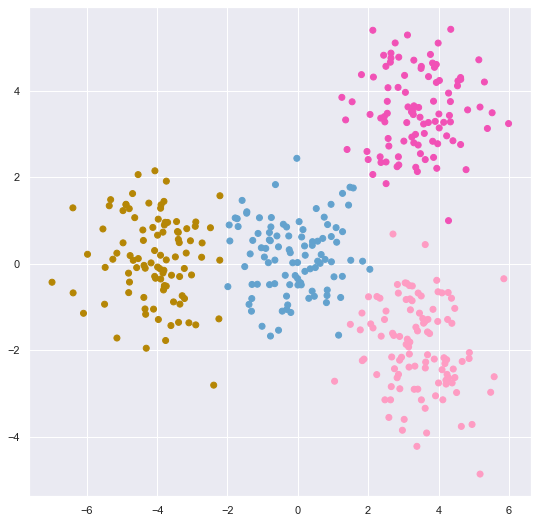

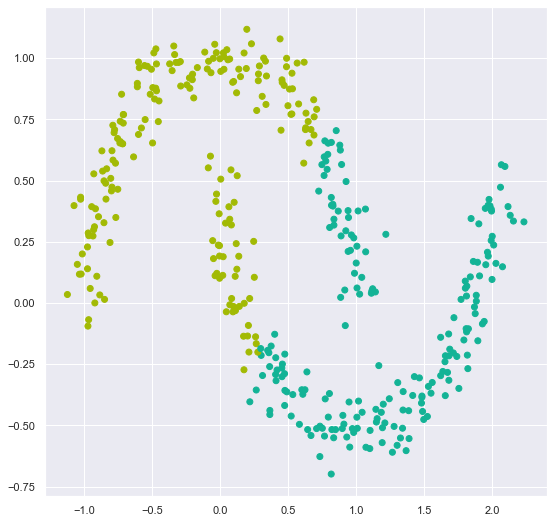

In [5]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric

    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        kdtree = KDTree(X, leaf_size = self.leaf_size, metric = self.metric)


        # 0 -- not visited
        # -1 -- noise
        # 1+ -- visited and assigned to corr. clst
        clst = 0
        label = -np.ones(X.shape[0], dtype=np.int)
        neighbors_all = kdtree.query_radius(X, self.eps)  # preprocessing
        for i_p in range(X.shape[0]):
            if label[i_p] != -1:
                continue

            neighbors = deque(neighbors_all[i_p])
            if len(neighbors) - 1 < self.min_samples:  # if not enough points => do nothing
                continue
            
            label[i_p] = clst

            while neighbors:
                q = neighbors.pop()
                if label[q] != -1:  # already visited
                    continue
                label[q] = clst
                n_neighbors = neighbors_all[q]
                if n_neighbors.shape[0] - 1 >= self.min_samples:
                    neighbors.extendleft(n_neighbors)
            clst += 1
        label[label == -1] = clst
        return label


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

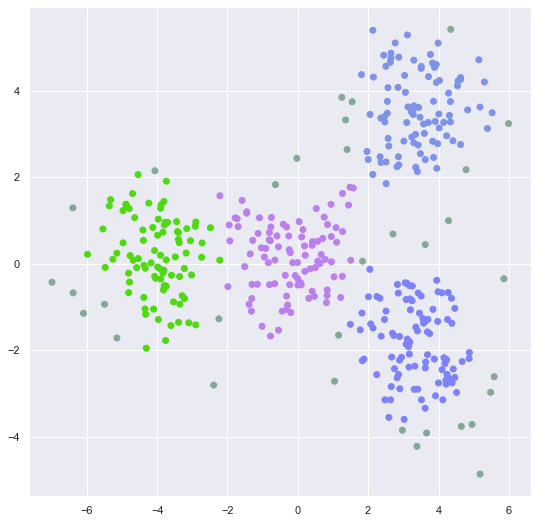

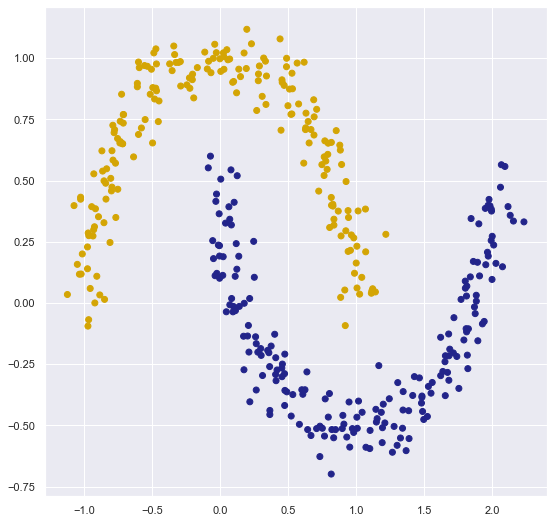

In [7]:
dbscan = DBScan(min_samples=10, eps=0.75)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(min_samples=10, eps=0.22)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [8]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
    

    def _get_distances(self, X, Y):
        D = np.sqrt(np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1, keepdims=True) - 2 * X @ Y.T)
        np.fill_diagonal(D, np.nan)
        return D

    def _merge(self, D, x_idx, y_idx):
        if self.linkage == "single":
            D[x_idx, :] = D[:, x_idx] = np.amin([D[x_idx], D[y_idx]], axis=0)
        elif self.linkage == "complete":
            D[x_idx, :] = D[:, x_idx] = np.amax([D[x_idx], D[y_idx]], axis=0)
        D[y_idx, :] = D[:, y_idx] = np.nan


    def _get_min_idx(self, D):
        k = np.nanargmin(D)
        ncol = D.shape[1]
        return k // ncol, k % ncol

    def _update_labels(self, labels, x_idx, y_idx):
        labels[labels == y_idx] = labels[x_idx]


    def _get_cluster_points(self, labels, label):
        return np.where(labels == label)[0]

    
    def _get_num_cluster_points(self, labels, label):
        return np.sum(labels == label)


    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """

        labels = np.arange(X.shape[0])

        D = self._get_distances(X, X)
        if self.linkage == "average":
            clusters = X.reshape(-1, 1, 2)
            D_average = D
            for i in range(X.shape[0] - self.n_clusters):
                x_idx, y_idx = self._get_min_idx(D_average)

                A_size = self._get_num_cluster_points(labels, labels[x_idx])
                B_size = self._get_num_cluster_points(labels, labels[y_idx])
                self._update_labels(labels, x_idx, y_idx)  # y -> x
                C_size = A_size + B_size

                for x_label in np.unique(labels):
                    if x_label == labels[x_idx]:
                        continue
                    X = self._get_cluster_points(labels, x_label)
                    
                    # https://en.wikipedia.org/wiki/UPGMA
                    D_average[x_idx, X] = D_average[X, x_idx] = (A_size * D_average[x_idx, X] + B_size * D_average[y_idx, X]) / C_size
                D[y_idx, :] = D[:, y_idx] = np.nan
        else:
            for _ in range(X.shape[0] - self.n_clusters):
                x_idx, y_idx = self._get_min_idx(D)
                self._update_labels(labels, x_idx, y_idx)
                self._merge(D, x_idx, y_idx)

        unique_labels = np.unique(labels)
        for cnt in range(self.n_clusters):
            labels[labels == unique_labels[cnt]] = cnt
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

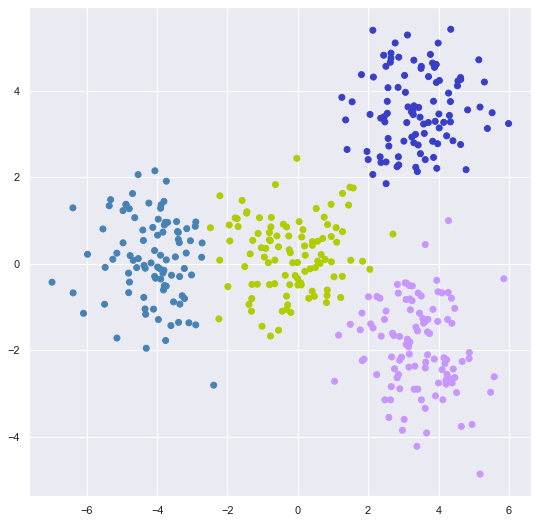

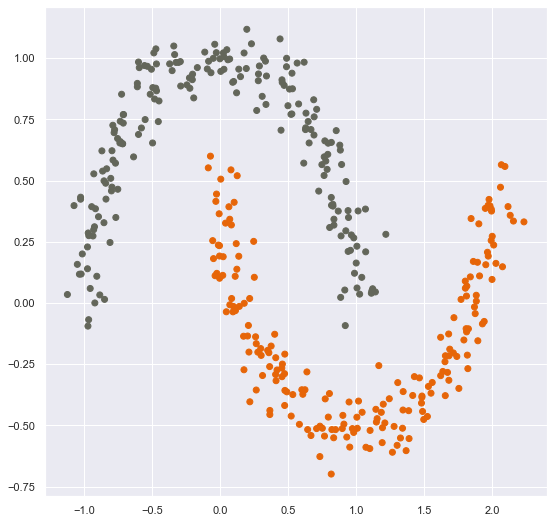

In [9]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [10]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    norm_img = cv2.normalize(img_rgb, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm_img



def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image_bgr)

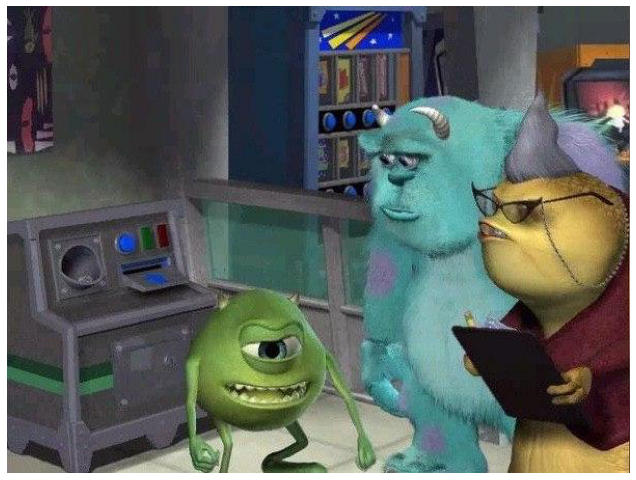

In [11]:
show_image(read_image("./mike.jpg"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [12]:
def recolor(image, n_clusters=4, predicator: str = "kmeans"):
    X = image.reshape((-1, 3)).copy()

    if predicator == "kmeans":
        kmeans = KMeans(n_clusters=n_clusters, init="random")
        kmeans.fit(X)
        labels = kmeans.predict(X)
    elif predicator == "dbscan":
        dbscan = DBScan(eps = 0.5, min_samples = n_clusters, leaf_size = 40, metric = "euclidean")
        labels = dbscan.fit_predict(X)
    elif predicator == "agg":
        agg = AgglomertiveClustering(n_clusters = n_clusters, linkage = "average")
        labels = agg.fit_predict(X)

    clst_clr = np.zeros(shape=(n_clusters, 3))
    for idx, lab in enumerate(np.unique(labels)):
        clst_clr[idx] = np.mean(X[labels == lab], axis=0)
        X[labels == lab] = clst_clr[idx]
    return clst_clr, labels, X

In [13]:
def clusterize_image(image, cluster_colors = None, clusters = None, recolored = None):    
    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters)  # Very slow (:
    return recolored.reshape(image.shape)

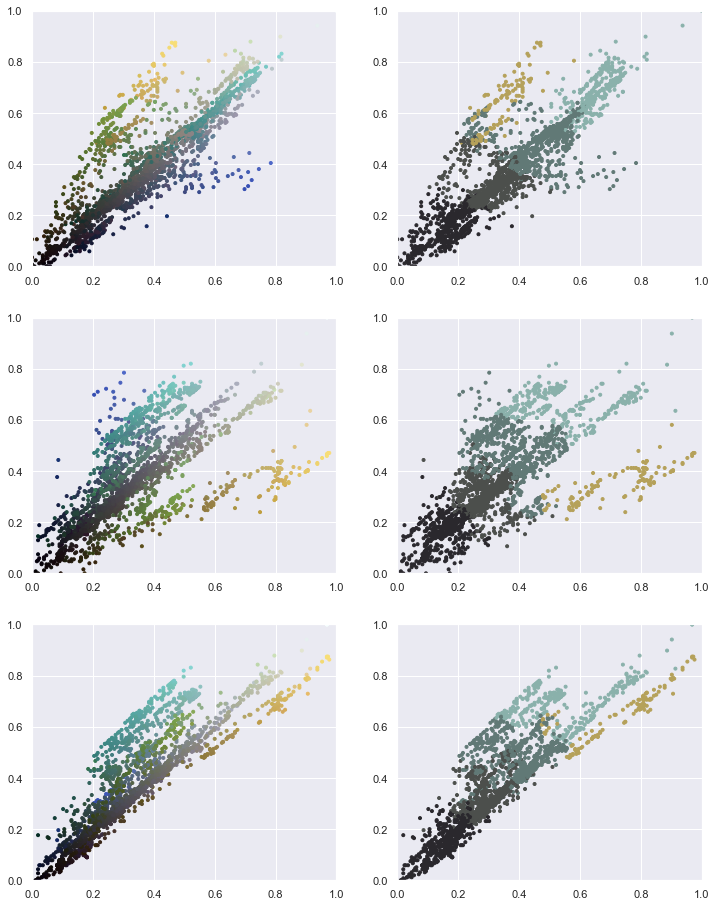

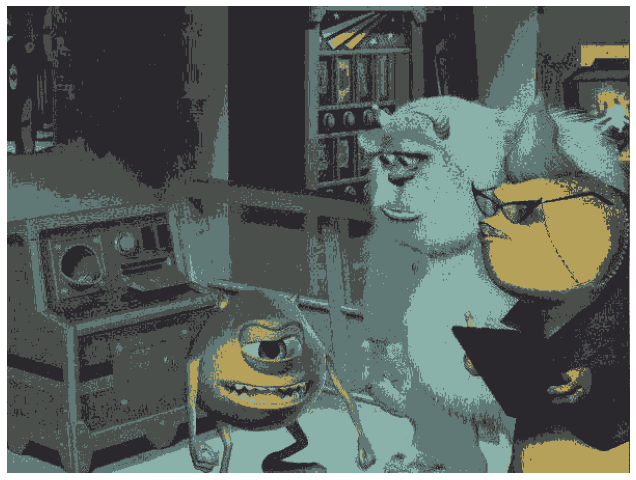

Wall time: 4.57 s


In [14]:
n = 5
pred = "kmeans"
image = read_image("./mike.jpg")
cluster_colors, cluster, recolored = recolor(image, n_clusters=n, predicator=pred)
result = clusterize_image(image, cluster_colors, cluster, recolored)
show_image(result)
save_image(result, "result_mike.jpg")